<a href="https://colab.research.google.com/github/wkdalsgh192/Web-Music-Recommendation/blob/develop/Music_Recommend_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 음악 추천 시스템 

## Importing Library

In [ ]:
!pip install spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy

     |████████████████████████████████| 153kB 17.4MB/s 
     |████████████████████████████████| 61kB 5.3MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import os
import librosa
import librosa.display

import IPython.display as ipd
from IPython.display import Audio
from IPython.display import HTML, display
import time
import requests

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
import pprint

In [ ]:
!pip freeze > requirements.txt

In [ ]:
!ls

requirements.txt  sample_data


In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


### Load Kaggle Dataset
we will load audio dataset from kaggle. For this, we first need to get API Token in the Account Setting and set your kaggle name and secret key in the config.

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'minolab'
os.environ['KAGGLE_KEY'] = '5bb8e0690fc7051a8518cff4de67b14c'

Now, you can download any dataset from Kaggle. we will bring the audio data that Andrada provide. Once it's done, we have to unzip the file to explore the data.

In [ ]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

100% 1.21G/1.21G [00:18<00:00, 48.8MB/s]
100% 1.21G/1.21G [00:18<00:00, 68.6MB/s]


In [ ]:
!unzip -q gtzan-dataset-music-genre-classification.zip

### Set up Directory
make a directory to save all the music files

In [ ]:
!rm -rf 'Audio' && ls
!mkdir 'Audio' && ls

Data  gtzan-dataset-music-genre-classification.zip  sample_data
Audio  Data  gtzan-dataset-music-genre-classification.zip  sample_data


## Common Methods

In [ ]:
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [ ]:
def normalize(x, axis=0):
  return sklearn.preprocessing.minmax_scale(x, axis=axis)

In [ ]:
def download_file(url):
    local_filename = url.split('/')[-1]
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open('./Audio/'+local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                f.write(chunk)
    return local_filename

## EDA
There are 10 genres with 100 audio files each, all having a length of 30 sec.
First, we pick up one of them and see how it looks using `librosa` library

In [ ]:
# Import 1 file
y,sr = librosa.load('Data/genres_original/reggae/reggae.00030.wav')

print(y)
print(len(y))
print('Sampling rate (KHz) : %d' %sr)

# Verify length of the audio
print('Audio length (sec) : %.2f' % (len(y)/sr))

# Try listen to it
ipd.Audio(y, rate=sr)

[ 0.00253296  0.00289917  0.0067749  ... -0.01333618 -0.01696777
 -0.01733398]
661794
Sampling rate (KHz) : 22050
Audio length (sec) : 30.01


**2D Representation : Sound Waves**

Draw the wave plot of the audio

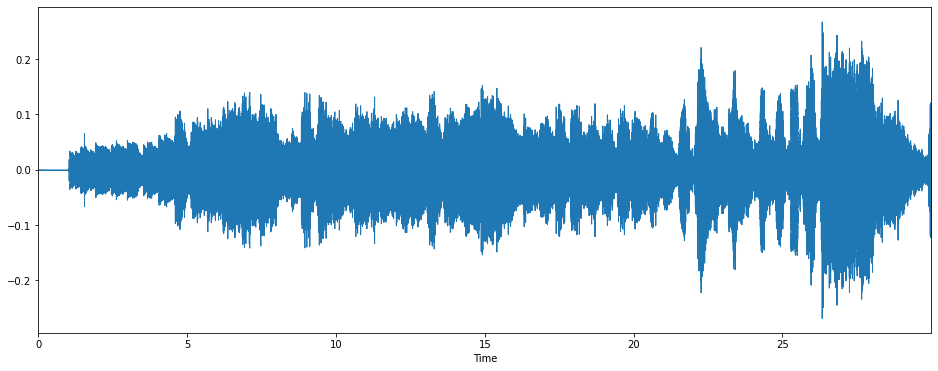

In [ ]:
plt.figure(figsize=(16,6))
librosa.display.waveplot(y=y,sr=sr)
plt.show()

**Fourier Transform**

Get a signal in the time domain as input, and transform its decomposition into frequencies as outputs.
- y-axis : frequency (log scale)
- colors : amplitude (Decibels)


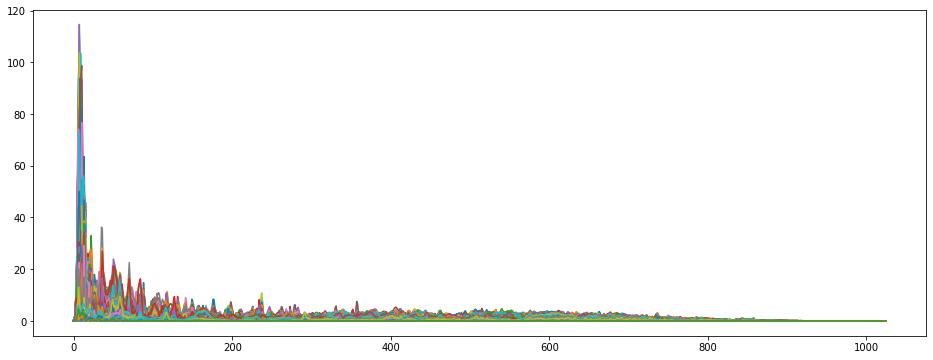

In [ ]:
# log scale of amplitudes
# Short-time Fourier Transform(STFT)
D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))

plt.figure(figsize=(16,6))
plt.plot(D)
plt.show()

**Spectrogram**

A visual representation of frequencies of a signal as it varies with time.

We convert the frequency axis to a logarithmatic one 

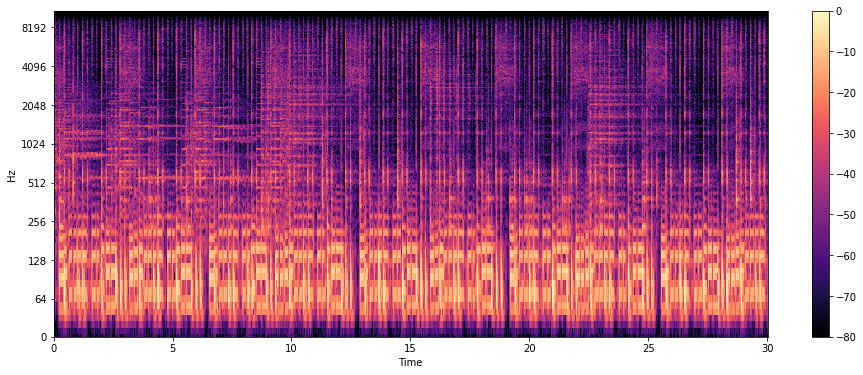

In [ ]:
B=librosa.amplitude_to_db(D, ref=np.max)
plt.figure(figsize=(16,6))
librosa.display.specshow(DB, sr=sr,hop_length=512,x_axis='time',y_axis='log')
plt.colorbar()
plt.show()

**Mel Spectrogram**

A normal Spectrogram, of which the y-axis mel-scaled. We get the result of some non-linear transformation of the frequency scale. 

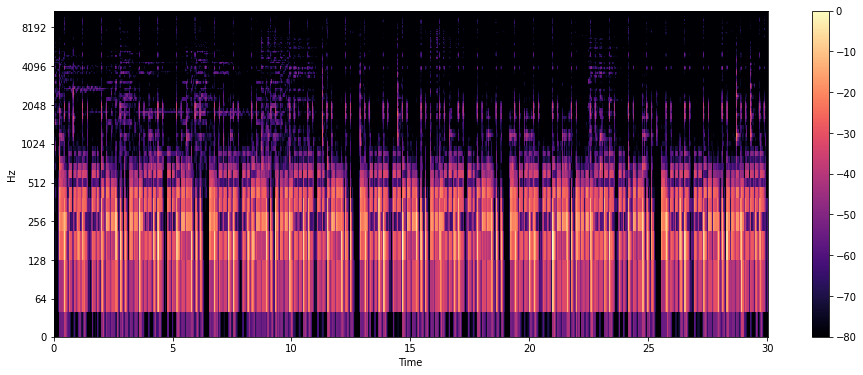

In [ ]:
S = librosa.feature.melspectrogram(y,sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)

plt.figure(figsize=(16,6))
librosa.display.specshow(S_DB,sr=sr,hop_length=512,x_axis='time',y_axis='log')
plt.colorbar()
plt.show()

## Extract Audio Feature

Here, we will cover various features that make the audio distinctive. 
- Zero Crossing Rate : the rate at which the signal changes from positive to negative and vice versa.
- Harmonics : an integer multiple of the fundamental frequency.
- [Percussion](https://www.encyclopedia.com/environment/encyclopedias-almanacs-transcripts-and-maps/percussion-and-noise) : a rhythmic patterning of noise, a precise structure and ordering of both pitch and timing, produced primarily by instruments of the idiophone and membranophone families, or indeed by the human body itself (in forms of clapping, stomping, or aspirating). 
- [Spectral Centroid](https://en.wikipedia.org/wiki/Spectral_centroid) : the center of mass of the spectrum is located
- [Spectral Rolloff](https://musicinformationretrieval.com/spectral_features.html) : the frequency below which a specified percentage of the total spectral energy, e.g. 85%, lies.
- Mel-Frequency Cepstral Coefficients(MFCCs) : a small set of features which concisely describe the overall shape of a spectral envelope. 
- [Chroma Frequencies](https://en.wikipedia.org/wiki/Chroma_feature) : a representation for music audio in which the entire spectrum is projected onto 12 bins representing the 12 distinct semitones of the musical octave.
- RMS(Root Mean Square) : a measure of the magnitude of a set of numbers.

  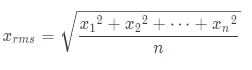

**Tempo (BPM)**

In [ ]:
tempo, _ = librosa.beat.beat_track(y, sr=sr)
print(tempo)

75.99954044117646


**Zero crossings**

In [ ]:
zero_crossings = librosa.zero_crossings(y,pad=False)
print(zero_crossings)
print(sum(zero_crossings))

[False False False ... False False False]
46715


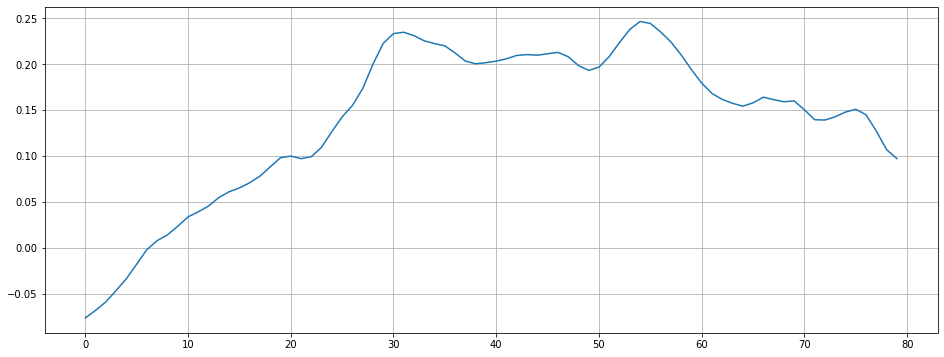

1


In [ ]:
plt.figure(figsize=(16,6))
plt.plot(y[9000:9080])
plt.grid()
plt.show()

zero_crossings = librosa.zero_crossings(y[9000:9080], pad=False)
print(sum(zero_crossings)) # 1

**Harmonics and Percussion**

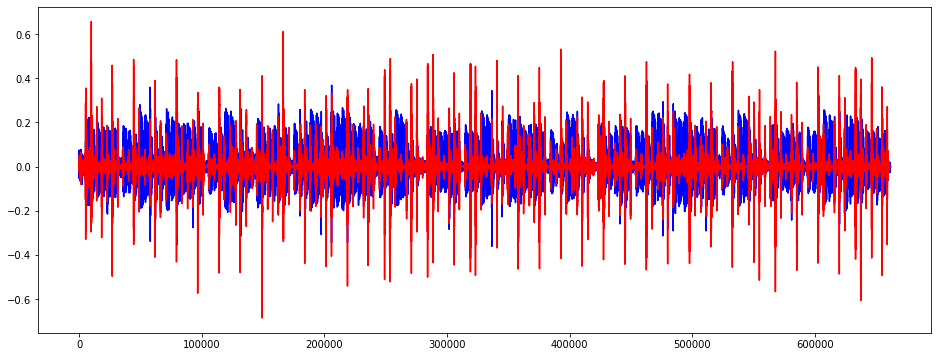

In [ ]:
y_harm, y_perc = librosa.effects.hpss(y)

plt.figure(figsize=(16,6))
plt.plot(y_harm, color='b')
plt.plot(y_perc,color='r')
plt.show()

**Spectral Centroids**

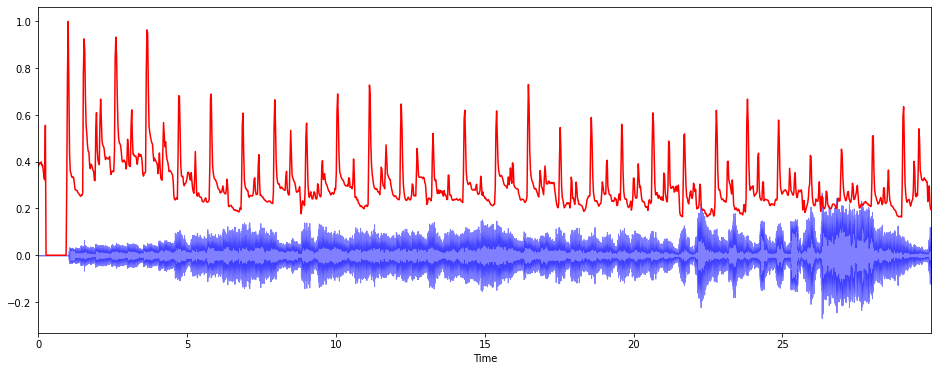

In [ ]:
spectral_centroids = librosa.feature.spectral_centroid(y, sr=sr)[0]

frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

plt.figure(figsize=(16,6))
librosa.display.waveplot(y, sr=sr, alpha=0.5, color='b')
plt.plot(t, normalize(spectral_centroids), color='r')
plt.show()

**Spectral Rolloff**

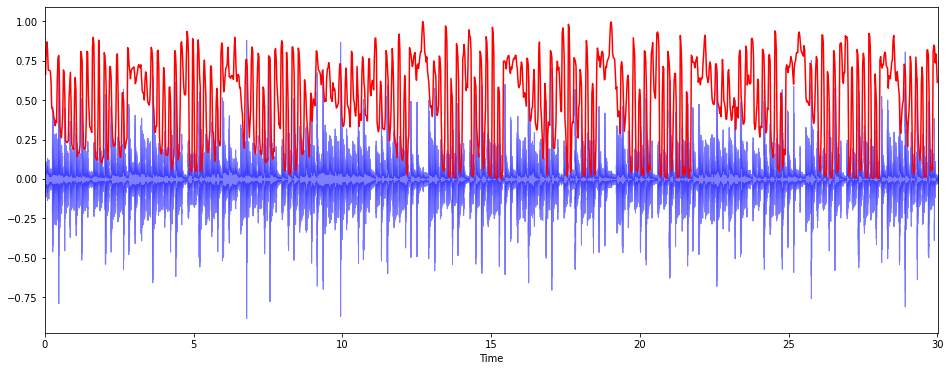

In [ ]:
spectral_rolloff = librosa.feature.spectral_rolloff(y,sr=sr)[0]

plt.figure(figsize=(16,6))
librosa.display.waveplot(y,sr=sr,alpha=0.5,color='b')
plt.plot(t,normalize(spectral_rolloff), color='r')
plt.show()

**MFCCs**

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


20
mean: 0.47
var: 0.03


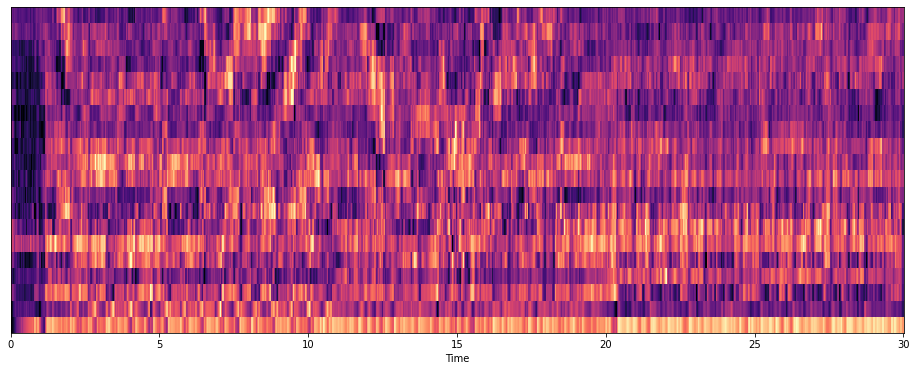

In [ ]:
y, sr = librosa.load('./'+audio_name,duration=30.0)
mfccs = librosa.feature.mfcc(y, sr=sr)
mfccs = normalize(mfccs,axis=1)

print(len(mfccs))

print('mean: %.2f' %mfccs.mean())
print('var: %.2f' % mfccs.var())

plt.figure(figsize=(16,6))
librosa.display.specshow(mfccs, sr=sr,x_axis='time')
plt.show()

**Chroma Frequencies**

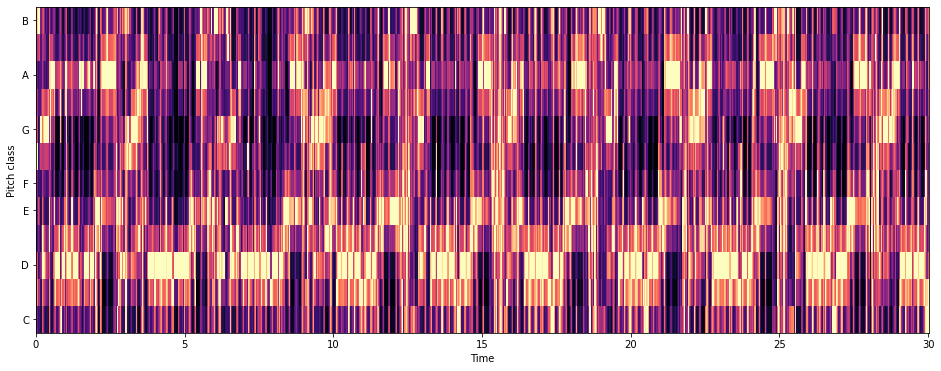

In [ ]:
chromagram = librosa.feature.chroma_stft(y, sr=sr, hop_length=512)

plt.figure(figsize=(16,6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512)
plt.show()

**RMS**

In [ ]:
rms = librosa.feature.rms(y, hop_length=512)
print(rms.mean())
print(rms.var())


0.35008812
0.08875657
0.13022792
0.0028266965


## Build Recommendation System

### K-Means Algorithm

In [ ]:
df = pd.read_csv('Data/features_30_sec.csv', index_col='filename')
df_pca = df.drop(['label','length'],axis=1)

df_pca.describe()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.378682,0.086340,0.130930,0.003051,2201.780898,4.696916e+05,2242.541070,137079.155165,4571.549304,1.844345e+06,0.103612,0.002986,-3.659332e-04,0.012540,-0.000395,5.670073e-03,119.505363,-144.472987,3747.875414,99.554278,706.899539,-8.920291,468.286436,36.292447,220.447219,-1.144840,174.404462,14.633491,127.232071,-5.129038,116.367019,10.119172,88.198988,-6.994062,88.566933,7.729785,81.733490,-6.021069,75.551228,4.471693,68.670817,-4.795884,67.871712,1.781900,64.764096,-3.869308,62.873761,1.148144,60.730958,-3.966028,62.633624,0.507696,63.712586,-2.328761,66.231930,-1.095348,70.126096
std,0.081705,0.007735,0.065683,0.003634,715.960600,4.008995e+05,526.316473,96455.666326,1574.791602,1.425085e+06,0.041821,0.003024,1.683946e-03,0.011653,0.001082,6.500325e-03,28.264176,100.229406,2770.558394,31.330873,439.120256,21.690676,287.143462,16.664665,116.236941,12.221340,100.767823,11.839591,68.475115,9.940460,58.400048,10.463270,41.048213,8.283921,39.494072,7.937309,36.733649,6.817013,38.135183,6.715787,32.625534,6.170181,33.154276,5.008385,34.450290,4.873599,33.904101,4.578948,33.781951,4.549697,33.479172,3.869105,34.401977,3.755957,37.174631,3.837007,45.228512
min,0.171939,0.044555,0.005276,0.000004,570.040355,7.911251e+03,898.066208,10787.185064,749.140636,1.468612e+04,0.021697,0.000044,-2.606458e-02,0.000049,-0.007150,8.299008e-07,54.978391,-552.120056,174.571365,-1.461542,93.104752,-89.870193,35.467754,-18.727547,34.263149,-38.890347,29.912008,-28.415911,20.847921,-32.930431,29.027332,-24.915823,22.464230,-31.640574,25.825863,-12.050177,19.273201,-28.057501,21.402756,-15.796446,18.642517,-27.523129,17.293922,-12.594489,14.250607,-17.539125,9.769691,-15.693844,9.169314,-17.234728,13.931521,-11.963694,15.420555,-18.501955,13.487622,-19.929634,7.956583
25%,0.319562,0.082298,0.086657,0.000942,1627.697311,1.843505e+05,1907.240605,67376.554428,3380.069642,7.727312e+05,0.070244,0.001079,-1.041584e-04,0.004383,-0.000537,1.292592e-03,99.384014,-200.763893,1844.488129,76.779915,398.020767,-24.219811,270.466576,24.108212,129.397377,-9.979157,101.266209,5.098573,76.505194,-12.870810,73.546917,1.609181,57.349041,-13.246939,59.882313,1.620753,55.734016,-10.964135,51.242420,-0.547371,46.854038,-9.357906,46.294396,-1.639417,43.416593,-7.165884,42.236251,-1.863280,40.376442,-7.207225,40.830875,-2.007015,41.884240,-4.662925,41.710184,-3.368996,42.372865
50%,0.383148,0.086615,0.122443,0.001816,2209.263090,3.384862e+05,2221.392843,111977.548036,4658.524473,1.476115e+06,0.099503,0.002022,-3.176783e-06,0.008768,-0.000036,3.410864e-03,117.453835,-120.286385,3135.16369

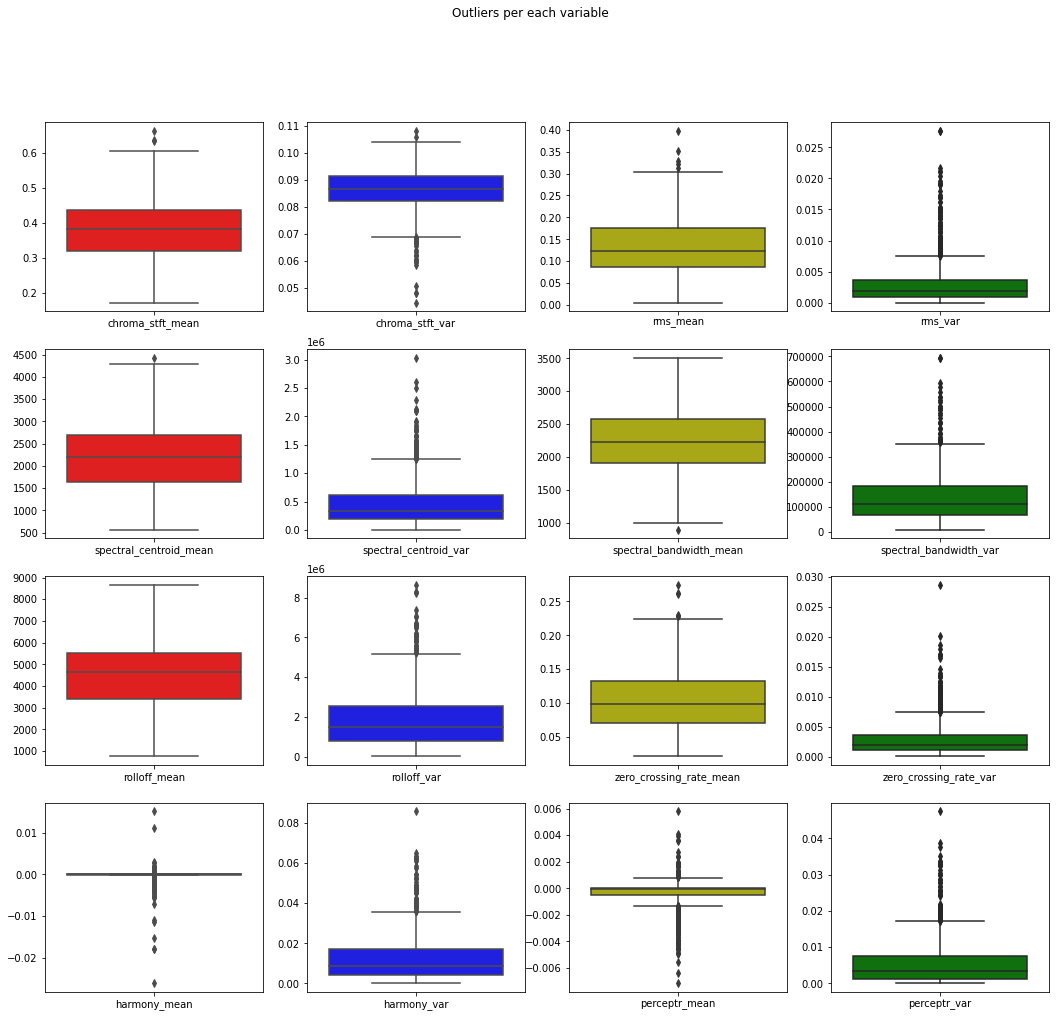

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(4,4, figsize=(18,16))
fig.suptitle('Outliers per each variable')
color=['r','b','y','g']
for i in range(0,4):
  for j in range(0,4):
    sns.boxplot(ax=axes[i,j], data=df_pca.iloc[:,[4*i+j]],color=color[j])

In [ ]:
def outliers_iqr(data):
  q1,q3 = np.percentile(data, [25,75])

  iqr = q3-q1
  lower_bound = q1 - (iqr*1.5)
  upper_bound = q3 + (iqr*1.5)

  return np.where((data>upper_bound)|(data<lower_bound))

res = outliers_iqr(df_pca.iloc[:,[56]])[0]
print(len(df_pca.columns))

outliers_idx = np.array([])
n = len(df_pca.columns)
for i in range(0,n):
  outliers_idx = np.concatenate((outliers_idx,outliers_iqr(df_pca.iloc[:,[i]])[0]),axis=None)

# print(len(outliers_idx))

57
1724


Index(['length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
       'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
       'label'

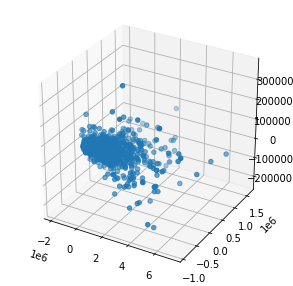

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pcc = pca.fit_transform(df_pca)
df_result = pd.DataFrame(data=pcc, columns=['X','Y','Z'])

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(df_result['X'],df_result['Y'],df_result['Z'])

plt.show()

In [ ]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=)

### Cos Similarity Recommendation

In [ ]:
def get_features(url):
  audio_path = './Audio/'
  filename = download_file(url+'.wav')
  path = librosa.feature
  y,sr = librosa.load(audio_path+filename,duration=30.0)
  
  chromagram = path.chroma_stft(y,sr=sr,hop_length=512)
  rms = path.rms(y, hop_length=512)
  centroids = path.spectral_centroid(y, sr=sr, hop_length=512)
  bandwidth = path.spectral_bandwidth(y, sr=sr, hop_length=512)
  rolloff = path.spectral_rolloff(y,sr=sr)[0]
  zero_crossings = librosa.zero_crossings(y, pad=False)
  harmony, perceptr = librosa.effects.hpss(y)
  mfccs = normalize(path.mfcc(y,sr=sr), axis=1)
  tempo, _ = librosa.beat.beat_track(y, sr=sr)

  f = [chromagram,rms,centroids,bandwidth,rolloff,zero_crossings,harmony,perceptr]
  r = []
  for i in f:
    r.extend([i.mean(),i.var()])
  else:
    r.append(tempo)
  
  for i in range(0,len(mfccs)):
    r.extend([mfccs[i].mean(),mfccs[i].var()])

  return r

In [ ]:
def customize(name,data):
  df = pd.read_csv('Data/features_30_sec.csv', index_col='filename')
  labels = list(df.index)

  df = df.drop(columns=['length','label'])
  labels.append(name)
  df=df.append(pd.Series(data,index=df.columns),ignore_index=True)

  df_scaled = sklearn.preprocessing.scale(df)
  df = pd.DataFrame(df_scaled,columns=df.columns)

  similarity = cosine_similarity(df)
  df_sim = pd.DataFrame(similarity, index=labels, columns=labels)
  return df_sim

In [ ]:
def find_similar_songs(name, data, n=10):
  
  series = data[name].sort_values(ascending=False)
  series = series.drop(name)
  return series.head(n).to_frame()

In [ ]:
from google.colab import files

f = files.upload()
audio_name = [k for k in f.keys()][0]

Saving AcousticJazz.wav to AcousticJazz.wav


In [ ]:
result = get_features('./'+audio_name)
df = customize(audio_name,result)
find_similar_songs(audio_name,df)

,AcousticJazz.wav
disco.00028.wav,0.508507
jazz.00082.wav,0.484129
pop.00004.wav,0.453779
pop.00008.wav,0.414937
rock.00041.wav,0.406668
disco.00045.wav,0.403230
rock.00056.wav,0.390339
disco.00022.wav,0.389508
pop.00069.wav,0.385351
country.00014.wav,0.384269


## Data Mining

In [ ]:
# Should be empty first
!cd Audio && ls

/bin/bash: line 0: cd: Audio: No such file or directory


### Get Hobin's Table

In [ ]:
df_hobin = pd.read_csv('/drive/My Drive/musicfinal2.csv',index_col=0,encoding='cp949')
df_hobin.head()

,m_title,m_genre,m_artist,m_album,m_preview,m_img,m_popularity,m_id,m_artist_id,m_album_id,m_cnt,m_emotion,m_date,m_url
m_no,,,,,,,,,,,,,,
1,Dreaming with a Broken Heart,"neo mellow,pop,pop rock,singer-songwriter",John Mayer,Continuum,https://p.scdn.co/mp3-preview/7364aa498317a18f...,https://i.scdn.co/image/ab67616d0000b2737af5fd...,64,7keXdrB4mz57u4b8YkCwag,0hEurMDQu99nJRq8pTxO14,1Xsprdt1q9rOzTic7b9zYM,1,sad,2006-09-11,https://www.youtube.com/watch?v=UguyZtTAclQ
2,Two Is Better Than One (feat. Taylor Swift),"dance pop,neo mellow,neon pop punk,pop punk,po...",Boys Like Girls,Love Drunk,https://p.scdn.co/mp3-preview/59cef672f643870e...,https://i.scdn.co/image/ab67616d0000b27308a2b8...,66,1MaqkdFNIKPdpQGDzme5ss,0vWCyXMrrvMlCcepuOJaGI,7DphDayDRJ1NtRmveflFWD,2,sad,2009-09-07,https://www.youtube.com/watch?v=AW3RspM7v9M
3,I Have Nothing,"dance pop,pop,urban contemporary",Whitney Houston,The Bodyguard - Original Soundtrack Album,https://p.scdn.co/mp3-preview/c0f4dcce1ca7f614...,https://i.scdn.co/image/ab67616d0000b273456c0b...,74,31er9IGsfFbwqy1pH4aiTP,6XpaIBNiVzIetEPCWDvAFP,7JVJlkNNobS0GSoy4tCS96,1,sad,1992-11-17,https://www.youtube.com/watch?v=FxYw0XPEoKE
4,Bleeding Love,"british soul,dance pop,europop,pop,pop dance,p...",Leona Lewis,Spirit,https://p.scdn.co/mp3-preview/dcd222d99771638d...,https://i.scdn.co/image/ab67616d0000b273e6ad6a...,69,6LtPIXlIzPOTF8vTecYjRe,5lKZWd6HiSCLfnDGrq9RAm,7t1veDv7FWHYXskQEoU7dq,1,sad,2007,https://www.youtube.com/watch?v=Vzo-EL_62fQ
5,Dance With My Father,"funk,motown,neo soul,new jack swing,quiet stor...",Luther Vandross,Dance With My Father,https://p.scdn.co/mp3-preview/17691ee287137ada...,https://i.scdn.co/image/ab67616d0000b2732ff5c4...,62,7snmvZMLdGGk3l9PcvoYSM,19y5MFBH7gohEdGwKM7QsP,43Ci8cugIRwfmkXEyEgfVM,1,sad,2003-06-10,https://www.youtube.com/watch?v=wmDxJrggie8


In [ ]:
client_id="f244c17b7e864e84b355f04cdedb22ff"
client_secret = "be1729d17f274a068dd9b70ee7c982fb"

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

def search(genre,n=10000):
  arr = []
  emotion=['기쁨','공포','놀라움','혐오','분노','슬픔','신뢰','기대']
 
  for i in range(0,n,50):
    try:
      results = sp.search(q='genre:' + genre, type='track',offset=i,limit=50)
      tracks = results['tracks']['items']
      for track in tracks:
          if track['preview_url'] is not None:
            arr.append([track['name'],genre,track['artists'][0]['name'],track['album']['name'],track['preview_url'],
                        track['album']['images'][0]['url'],track['popularity'],track['id'],track['artists'][0]['id'],
                        track['album']['id'], 0, emotion[i%8],track['album']['release_date'],None])
          else:
              pass
    except:
      break

  df_gen = pd.DataFrame(arr, columns=df_hobin.columns)      
  return df_gen

In [ ]:
def restructure(df, col_name):
  df_sample = pd.read_csv('Data/features_30_sec.csv', index_col='filename')
  df_sample = df_sample.drop(columns=['length','label'])
  cols=df_sample.columns

  df = df.drop_duplicates(col_name[0],keep='first') # drop duplicate values in 'id' column
  df = df.reset_index(drop=True).loc[:,col_name]
  for col in cols:
    df.loc[:,col]=''

  return df

In [ ]:
genres = ['blues','classical','country','disco','hip hop','jazz','metal','pop','reggae','rock']
frames =[]
for genre in genres:
  frames.append(search(genre))

df_result = pd.concat(frames)
df_result.shape

HTTP Error for GET to https://api.spotify.com/v1/search returned 404 due to Not found.
HTTP Error for GET to https://api.spotify.com/v1/search returned 404 due to Not found.
HTTP Error for GET to https://api.spotify.com/v1/search returned 404 due to Not found.
HTTP Error for GET to https://api.spotify.com/v1/search returned 404 due to Not found.
HTTP Error for GET to https://api.spotify.com/v1/search returned 404 due to Not found.
HTTP Error for GET to https://api.spotify.com/v1/search returned 404 due to Not found.
HTTP Error for GET to https://api.spotify.com/v1/search returned 404 due to Not found.
HTTP Error for GET to https://api.spotify.com/v1/search returned 404 due to Not found.
HTTP Error for GET to https://api.spotify.com/v1/search returned 404 due to Not found.
HTTP Error for GET to https://api.spotify.com/v1/search returned 404 due to Not found.


(5584, 14)

In [ ]:
df_result.to_csv('/drive/My Drive/add_music.csv')
df_total=df_hobin.append(df_result, ignore_index=True)
df_total = df_total.drop_duplicates('m_id',keep='first')
df_total.to_csv('/drive/My Drive/musictotal.csv')
df_total.shape

In [ ]:
df_result.groupby(['genre']).count()

,artist,title,id,url
genre,,,,
blues,604,604,604,604
classical,225,225,225,225
country,585,585,585,585
disco,618,618,618,618
hip hop,740,740,740,740
jazz,677,677,677,677
metal,712,712,712,712
pop,518,518,518,518
reggae,514,514,514,514


In [ ]:
df_final = restructure(df_hobin,['m_id','m_preview'])
df_final.shape

out = display(progress(0, len(df_final)), display_id=True)
for i in range(0,len(df_final)): # 5시간 걸림
  try:
    df_final.iloc[i,2:] = get_features(df['m_preview'].iloc[i])
        
  except:
    df_final.iloc[i,2:] = np.nan
  finally:
    if i%10==0:
      time.sleep(0.02)
      out.update(progress(i+1,len(df_final)))

# export dataframe to drive in csv
df_final.to_csv('/drive/My Drive/audio_transition_data2.csv')


In [ ]:
df_final1 = pd.read_csv('/drive/My Drive/audio_transition_data.csv',index_col=0)
df_final1.head()

,artist,title,genre,id,url,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,Leon Bridges,River,blues,3hhbDnFUb2bicI2df6VurK,https://p.scdn.co/mp3-preview/6962fa9418840479...,0.340532,0.087652,0.127113,0.009826,2581.566101,1.053088e+06,2403.276958,159790.500869,5124.652345,2.574437e+06,0.141563,0.121523,0.000008,0.012625,0.000068,0.006160,89.102909,0.523824,0.066928,0.654140,0.027584,0.549985,0.056685,0.413389,0.030003,0.566251,0.036899,0.507731,0.037065,0.576530,0.030819,0.501694,0.035674,0.526428,0.033255,0.495845,0.029518,0.469918,0.025007,0.530838,0.031665,0.458754,0.027738,0.392587,0.023186,0.491017,0.033565,0.447741,0.028504,0.498720,0.030705,0.478875,0.023933,0.547008,0.019667,0.518408,0.025951
1,Al Green,Let's Stay Together,blues,63xdwScd1Ai1GigAwQxE8y,https://p.scdn.co/mp3-preview/5374059cb5947b59...,0.386068,0.092130,0.187680,0.006038,1455.233586,4.222469e+05,1944.156397,254355.164017,3218.705537,2.371233e+06,0.050822,0.048239,0.000002,0.018428,-0.000027,0.012325,103.359375,0.516215,0.047439,0.609208,0.022159,0.465211,0.022635,0.428405,0.014719,0.515630,0.048294,0.439484,0.019518,0.542363,0.027879,0.642018,0.022010,0.455378,0.033807,0.478697,0.022191,0.554607,0.023141,0.575643,0.022480,0.398240,0.019319,0.332724,0.013851,0.451649,0.017105,0.416931,0.017678,0.371697,0.026094,0.506014,0.025565,0.401616,0.026384,0.453155,0.024243
2,Leon Bridges,Beyond,blues,1Omt5bfz1tZUCqd26HxbS0,https://p.scdn.co/mp3-preview/c2ec433b724bbd36...,0.331031,0.094940,0.284955,0.008524,1990.323169,3.071329e+05,2329.933205,129253.425862,4240.599358,2.116133e+06,0.082724,0.075881,0.000039,0.053693,0.000357,0.018393,75.999540,0.562786,0.026564,0.522311,0.028151,0.403829,0.023117,0.583897,0.022935,0.537594,0.022841,0.533897,0.026878,0.512799,0.031830,0.557866,0.025343,0.491680,0.027409,0.572093,0.029952,0.562077,0.022321,0.556572,0.016841,0.431288,0.027237,0.546530,0.017930,0.462145,0.030010,0.502020,0.025431,0.482515,0.028023,0.517865,0.025794,0.492658,0.027436,0.554036,0.022065
3,Otis Redding,(Sittin' On) the Dock of the Bay,blues,3zBhihYUHBmGd2bcQIobrF,https://p.scdn.co/mp3-preview/99bfd8043cd20bc3...,0.326162,0.093312,0.168897,0.004578,1493.908543,3.746741e+05,1960.771521,201518.441244,3091.806304,2.306604e+06,0.055306,0.052247,0.000002,0.019370,-0.000033,0.005336,103.359375,0.548791,0.037903,0.627550,0.020262,0.527185,0.022505,0.588136,0.024114,0.517246,0.031364,0.571874,0.022690,0.573673,0.017842,0.509718,0.017146,0.563073,0.018427,0.474059,0.022377,0.520827,0.029049,0.465475,0.023645,0.430790,0.021815,0.456413,0.021869,0.514212,0.028046,0.367733,0.020998,0.464453,0.019796,0.390420,0.017702,0.497666,0.031083,0.416155,0.023025
4,Everybody Loves an Outlaw,I See Red,blues,5MAK1nd8R6PWnle1Q1WJvh,https://p.scdn.co/mp3-preview/df4b5a5cfd4a66af...,0.456626,0.081572,0.312644,0.001946,2108.251056,2.178353e+05,2359.434879,125000.876698,4633.555315,1.168767e+06,0.074552,0.068994,-0.000013,0.075300,-0.000022,0.008430,161.499023,0.516598,0.025108,0.437740,0.026811,0.507683,0.034745,0.407142,0.033186,0.568697,0.027836,0.524771,0.026549,0.438686,0.024906,0.489140,0.025221,0.380459,0.018792,0.464510,0.016997,0.480043,0.026184,0.493864,0.024798,0.451483,0.015140,0.490225,0.021695,0.475655,0.024476,0.475452,0.026008,0.418883,0.019212,0.526161,0.027509,0.536365,0.029461,0.537691,0.024658


In [ ]:
df_final1 = df_final1.drop(columns=['artist','title','genre'])
df_final1=df_final1.rename(columns={'id':'m_id','url':'m_preview'})
df_final1.head()

,m_id,m_preview,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,3hhbDnFUb2bicI2df6VurK,https://p.scdn.co/mp3-preview/6962fa9418840479...,0.340532,0.087652,0.127113,0.009826,2581.566101,1.053088e+06,2403.276958,159790.500869,5124.652345,2.574437e+06,0.141563,0.121523,0.000008,0.012625,0.000068,0.006160,89.102909,0.523824,0.066928,0.654140,0.027584,0.549985,0.056685,0.413389,0.030003,0.566251,0.036899,0.507731,0.037065,0.576530,0.030819,0.501694,0.035674,0.526428,0.033255,0.495845,0.029518,0.469918,0.025007,0.530838,0.031665,0.458754,0.027738,0.392587,0.023186,0.491017,0.033565,0.447741,0.028504,0.498720,0.030705,0.478875,0.023933,0.547008,0.019667,0.518408,0.025951
1,63xdwScd1Ai1GigAwQxE8y,https://p.scdn.co/mp3-preview/5374059cb5947b59...,0.386068,0.092130,0.187680,0.006038,1455.233586,4.222469e+05,1944.156397,254355.164017,3218.705537,2.371233e+06,0.050822,0.048239,0.000002,0.018428,-0.000027,0.012325,103.359375,0.516215,0.047439,0.609208,0.022159,0.465211,0.022635,0.428405,0.014719,0.515630,0.048294,0.439484,0.019518,0.542363,0.027879,0.642018,0.022010,0.455378,0.033807,0.478697,0.022191,0.554607,0.023141,0.575643,0.022480,0.398240,0.019319,0.332724,0.013851,0.451649,0.017105,0.416931,0.017678,0.371697,0.026094,0.506014,0.025565,0.401616,0.026384,0.453155,0.024243
2,1Omt5bfz1tZUCqd26HxbS0,https://p.scdn.co/mp3-preview/c2ec433b724bbd36...,0.331031,0.094940,0.284955,0.008524,1990.323169,3.071329e+05,2329.933205,129253.425862,4240.599358,2.116133e+06,0.082724,0.075881,0.000039,0.053693,0.000357,0.018393,75.999540,0.562786,0.026564,0.522311,0.028151,0.403829,0.023117,0.583897,0.022935,0.537594,0.022841,0.533897,0.026878,0.512799,0.031830,0.557866,0.025343,0.491680,0.027409,0.572093,0.029952,0.562077,0.022321,0.556572,0.016841,0.431288,0.027237,0.546530,0.017930,0.462145,0.030010,0.502020,0.025431,0.482515,0.028023,0.517865,0.025794,0.492658,0.027436,0.554036,0.022065
3,3zBhihYUHBmGd2bcQIobrF,https://p.scdn.co/mp3-preview/99bfd8043cd20bc3...,0.326162,0.093312,0.168897,0.004578,1493.908543,3.746741e+05,1960.771521,201518.441244,3091.806304,2.306604e+06,0.055306,0.052247,0.000002,0.019370,-0.000033,0.005336,103.359375,0.548791,0.037903,0.627550,0.020262,0.527185,0.022505,0.588136,0.024114,0.517246,0.031364,0.571874,0.022690,0.573673,0.017842,0.509718,0.017146,0.563073,0.018427,0.474059,0.022377,0.520827,0.029049,0.465475,0.023645,0.430790,0.021815,0.456413,0.021869,0.514212,0.028046,0.367733,0.020998,0.464453,0.019796,0.390420,0.017702,0.497666,0.031083,0.416155,0.023025
4,5MAK1nd8R6PWnle1Q1WJvh,https://p.scdn.co/mp3-preview/df4b5a5cfd4a66af...,0.456626,0.081572,0.312644,0.001946,2108.251056,2.178353e+05,2359.434879,125000.876698,4633.555315,1.168767e+06,0.074552,0.068994,-0.000013,0.075300,-0.000022,0.008430,161.499023,0.516598,0.025108,0.437740,0.026811,0.507683,0.034745,0.407142,0.033186,0.568697,0.027836,0.524771,0.026549,0.438686,0.024906,0.489140,0.025221,0.380459,0.018792,0.464510,0.016997,0.480043,0.026184,0.493864,0.024798,0.451483,0.015140,0.490225,0.021695,0.475655,0.024476,0.475452,0.026008,0.418883,0.019212,0.526161,0.027509,0.536365,0.029461,0.537691,0.024658


In [ ]:
print(df_hobin.columns)
df_concat = pd.DataFrame({'artist':df_hobin['m_artist'],'title':df_hobin['m_title'],'genre':df_hobin['m_genre'],'id':df_hobin['m_id']})
df_concat.head()

Index(['m_title', 'm_genre', 'm_artist', 'm_album', 'm_preview', 'm_img',
       'm_popularity', 'm_id', 'm_artist_id', 'm_album_id', 'm_cnt',
       'm_emotion', 'm_date', 'm_url'],
      dtype='object')


,artist,title,genre,id
m_no,,,,
1,John Mayer,Dreaming with a Broken Heart,"neo mellow,pop,pop rock,singer-songwriter",7keXdrB4mz57u4b8YkCwag
2,Boys Like Girls,Two Is Better Than One (feat. Taylor Swift),"dance pop,neo mellow,neon pop punk,pop punk,po...",1MaqkdFNIKPdpQGDzme5ss
3,Whitney Houston,I Have Nothing,"dance pop,pop,urban contemporary",31er9IGsfFbwqy1pH4aiTP
4,Leona Lewis,Bleeding Love,"british soul,dance pop,europop,pop,pop dance,p...",6LtPIXlIzPOTF8vTecYjRe
5,Luther Vandross,Dance With My Father,"funk,motown,neo soul,new jack swing,quiet stor...",7snmvZMLdGGk3l9PcvoYSM


In [ ]:
df_concat = pd.DataFrame({'artist':df_hobin['m_artist'],'title':df_hobin['m_title'],'genre':df_hobin['m_genre'],'id':df_hobin['m_id']})
df_concat = df_concat.merge(df_final2,left_on='id',right_on='m_id',how='inner')
df_concat = df_concat.drop(columns=['m_id']).rename(columns={'m_preview':'url'})
df_concat.to_csv('/drive/My Drive/audio_transition_data3.csv')

In [ ]:
df_final2 = pd.read_csv('/drive/My Drive/audio_transition_data2.csv', index_col=0)
df_final2.head()

,m_id,m_preview,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,7keXdrB4mz57u4b8YkCwag,https://p.scdn.co/mp3-preview/7364aa498317a18f...,0.407264,0.077867,0.294858,0.002014,1872.984664,188062.311803,2212.893630,110075.455362,4049.300514,1.289364e+06,0.074337,0.068811,-2.663383e-06,0.059549,-0.000025,0.009384,135.999178,0.469718,0.027184,0.629535,0.025111,0.465837,0.022945,0.535662,0.022819,0.592811,0.028048,0.589375,0.027395,0.381761,0.018766,0.636488,0.018045,0.479062,0.021784,0.476643,0.015230,0.448403,0.018934,0.580811,0.013699,0.501843,0.030236,0.434322,0.021759,0.504900,0.019421,0.538151,0.023656,0.562825,0.023722,0.518400,0.029196,0.462153,0.021253,0.458481,0.017926
1,1MaqkdFNIKPdpQGDzme5ss,https://p.scdn.co/mp3-preview/59cef672f643870e...,0.340682,0.080548,0.230829,0.008027,2582.935109,410268.623960,2512.622128,101060.106247,5400.417344,1.630928e+06,0.131758,0.114398,-5.312698e-06,0.037513,0.000079,0.009060,129.199219,0.708008,0.038910,0.611828,0.019705,0.427042,0.017369,0.649580,0.033904,0.433610,0.015787,0.483330,0.019822,0.528833,0.024558,0.574529,0.024937,0.476114,0.021506,0.556428,0.023127,0.652817,0.019619,0.555177,0.025242,0.540620,0.030182,0.527612,0.023210,0.581903,0.023350,0.594552,0.022157,0.543426,0.020622,0.507248,0.027017,0.592936,0.024053,0.502383,0.032110
2,31er9IGsfFbwqy1pH4aiTP,https://p.scdn.co/mp3-preview/c0f4dcce1ca7f614...,0.285898,0.090378,0.140768,0.002447,2530.753710,333953.710829,2552.503591,100648.350268,5162.418784,2.240122e+06,0.130881,0.113751,-8.472301e-07,0.015029,-0.000069,0.002646,151.999081,0.517724,0.034107,0.611291,0.020058,0.395320,0.011038,0.557367,0.019969,0.496363,0.025298,0.553051,0.017467,0.468186,0.034520,0.646848,0.019048,0.514454,0.027733,0.390577,0.027046,0.499141,0.025891,0.470082,0.024971,0.499450,0.032496,0.494576,0.030550,0.608173,0.019199,0.462893,0.027604,0.500730,0.028839,0.500182,0.028908,0.526532,0.026680,0.463207,0.025439
3,6LtPIXlIzPOTF8vTecYjRe,https://p.scdn.co/mp3-preview/dcd222d99771638d...,0.350707,0.096620,0.251311,0.003754,2445.247322,759294.632585,2474.278236,161341.988935,4929.228527,2.795713e+06,0.110701,0.098447,7.017603e-06,0.039622,0.000217,0.012184,103.359375,0.591200,0.025263,0.524169,0.033070,0.324519,0.016859,0.525350,0.017270,0.449802,0.025598,0.593604,0.019212,0.505243,0.018342,0.558376,0.022009,0.473966,0.026771,0.426377,0.037762,0.498490,0.017831,0.464703,0.021930,0.503317,0.019037,0.488411,0.017849,0.575209,0.023551,0.507265,0.019643,0.445748,0.021794,0.459204,0.021394,0.360199,0.016576,0.474112,0.026856
4,7snmvZMLdGGk3l9PcvoYSM,https://p.scdn.co/mp3-preview/17691ee287137ada...,0.347182,0.088366,0.151995,0.003361,2115.770005,958507.938552,2547.821723,251822.357037,4650.471879,4.026986e+06,0.079911,0.073525,9.319059e-06,0.015182,0.000008,0.004892,161.499023,0.455420,0.035575,0.573927,0.036169,0.369332,0.021826,0.558859,0.022735,0.518236,0.027117,0.518763,0.028478,0.512132,0.033061,0.562783,0.028327,0.474299,0.026495,0.573521,0.024154,0.538631,0.024627,0.650035,0.019003,0.442920,0.023362,0.478852,0.034177,0.557741,0.027980,0.428727,0.027478,0.478348,0.020525,0.497657,0.022367,0.528983,0.021197,0.553017,0.027632


In [ ]:
df_final = df_final2.append(df_final1,ignore_index=True)
df_final = df_final.drop_duplicates('m_id',keep='first')
df_final.head()

,m_id,m_preview,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,7keXdrB4mz57u4b8YkCwag,https://p.scdn.co/mp3-preview/7364aa498317a18f...,0.407264,0.077867,0.294858,0.002014,1872.984664,188062.311803,2212.893630,110075.455362,4049.300514,1.289364e+06,0.074337,0.068811,-2.663383e-06,0.059549,-0.000025,0.009384,135.999178,0.469718,0.027184,0.629535,0.025111,0.465837,0.022945,0.535662,0.022819,0.592811,0.028048,0.589375,0.027395,0.381761,0.018766,0.636488,0.018045,0.479062,0.021784,0.476643,0.015230,0.448403,0.018934,0.580811,0.013699,0.501843,0.030236,0.434322,0.021759,0.504900,0.019421,0.538151,0.023656,0.562825,0.023722,0.518400,0.029196,0.462153,0.021253,0.458481,0.017926
1,1MaqkdFNIKPdpQGDzme5ss,https://p.scdn.co/mp3-preview/59cef672f643870e...,0.340682,0.080548,0.230829,0.008027,2582.935109,410268.623960,2512.622128,101060.106247,5400.417344,1.630928e+06,0.131758,0.114398,-5.312698e-06,0.037513,0.000079,0.009060,129.199219,0.708008,0.038910,0.611828,0.019705,0.427042,0.017369,0.649580,0.033904,0.433610,0.015787,0.483330,0.019822,0.528833,0.024558,0.574529,0.024937,0.476114,0.021506,0.556428,0.023127,0.652817,0.019619,0.555177,0.025242,0.540620,0.030182,0.527612,0.023210,0.581903,0.023350,0.594552,0.022157,0.543426,0.020622,0.507248,0.027017,0.592936,0.024053,0.502383,0.032110
2,31er9IGsfFbwqy1pH4aiTP,https://p.scdn.co/mp3-preview/c0f4dcce1ca7f614...,0.285898,0.090378,0.140768,0.002447,2530.753710,333953.710829,2552.503591,100648.350268,5162.418784,2.240122e+06,0.130881,0.113751,-8.472301e-07,0.015029,-0.000069,0.002646,151.999081,0.517724,0.034107,0.611291,0.020058,0.395320,0.011038,0.557367,0.019969,0.496363,0.025298,0.553051,0.017467,0.468186,0.034520,0.646848,0.019048,0.514454,0.027733,0.390577,0.027046,0.499141,0.025891,0.470082,0.024971,0.499450,0.032496,0.494576,0.030550,0.608173,0.019199,0.462893,0.027604,0.500730,0.028839,0.500182,0.028908,0.526532,0.026680,0.463207,0.025439
3,6LtPIXlIzPOTF8vTecYjRe,https://p.scdn.co/mp3-preview/dcd222d99771638d...,0.350707,0.096620,0.251311,0.003754,2445.247322,759294.632585,2474.278236,161341.988935,4929.228527,2.795713e+06,0.110701,0.098447,7.017603e-06,0.039622,0.000217,0.012184,103.359375,0.591200,0.025263,0.524169,0.033070,0.324519,0.016859,0.525350,0.017270,0.449802,0.025598,0.593604,0.019212,0.505243,0.018342,0.558376,0.022009,0.473966,0.026771,0.426377,0.037762,0.498490,0.017831,0.464703,0.021930,0.503317,0.019037,0.488411,0.017849,0.575209,0.023551,0.507265,0.019643,0.445748,0.021794,0.459204,0.021394,0.360199,0.016576,0.474112,0.026856
4,7snmvZMLdGGk3l9PcvoYSM,https://p.scdn.co/mp3-preview/17691ee287137ada...,0.347182,0.088366,0.151995,0.003361,2115.770005,958507.938552,2547.821723,251822.357037,4650.471879,4.026986e+06,0.079911,0.073525,9.319059e-06,0.015182,0.000008,0.004892,161.499023,0.455420,0.035575,0.573927,0.036169,0.369332,0.021826,0.558859,0.022735,0.518236,0.027117,0.518763,0.028478,0.512132,0.033061,0.562783,0.028327,0.474299,0.026495,0.573521,0.024154,0.538631,0.024627,0.650035,0.019003,0.442920,0.023362,0.478852,0.034177,0.557741,0.027980,0.428727,0.027478,0.478348,0.020525,0.497657,0.022367,0.528983,0.021197,0.553017,0.027632


In [ ]:
# drop 'na' value
df_genre = df_final.dropna().set_index(['m_id'])
df_others = df_genre.iloc[:,0:2]
df_genre = df_genre.drop(columns=['m_preview'])
labels = list(df_genre.index)

In [ ]:
df_genre.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
m_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7keXdrB4mz57u4b8YkCwag,0.407264,0.077867,0.294858,0.002014,1872.984664,188062.311803,2212.893630,110075.455362,4049.300514,1.289364e+06,0.074337,0.068811,-2.663383e-06,0.059549,-0.000025,0.009384,135.999178,0.469718,0.027184,0.629535,0.025111,0.465837,0.022945,0.535662,0.022819,0.592811,0.028048,0.589375,0.027395,0.381761,0.018766,0.636488,0.018045,0.479062,0.021784,0.476643,0.015230,0.448403,0.018934,0.580811,0.013699,0.501843,0.030236,0.434322,0.021759,0.504900,0.019421,0.538151,0.023656,0.562825,0.023722,0.518400,0.029196,0.462153,0.021253,0.458481,0.017926
1MaqkdFNIKPdpQGDzme5ss,0.340682,0.080548,0.230829,0.008027,2582.935109,410268.623960,2512.622128,101060.106247,5400.417344,1.630928e+06,0.131758,0.114398,-5.312698e-06,0.037513,0.000079,0.009060,129.199219,0.708008,0.038910,0.611828,0.019705,0.427042,0.017369,0.649580,0.033904,0.433610,0.015787,0.483330,0.019822,0.528833,0.024558,0.574529,0.024937,0.476114,0.021506,0.556428,0.023127,0.652817,0.019619,0.555177,0.025242,0.540620,0.030182,0.527612,0.023210,0.581903,0.023350,0.594552,0.022157,0.543426,0.020622,0.507248,0.027017,0.592936,0.024053,0.502383,0.032110
31er9IGsfFbwqy1pH4aiTP,0.285898,0.090378,0.140768,0.002447,2530.753710,333953.710829,2552.503591,100648.350268,5162.418784,2.240122e+06,0.130881,0.113751,-8.472301e-07,0.015029,-0.000069,0.002646,151.999081,0.517724,0.034107,0.611291,0.020058,0.395320,0.011038,0.557367,0.019969,0.496363,0.025298,0.553051,0.017467,0.468186,0.034520,0.646848,0.019048,0.514454,0.027733,0.390577,0.027046,0.499141,0.025891,0.470082,0.024971,0.499450,0.032496,0.494576,0.030550,0.608173,0.019199,0.462893,0.027604,0.500730,0.028839,0.500182,0.028908,0.526532,0.026680,0.463207,0.025439
6LtPIXlIzPOTF8vTecYjRe,0.350707,0.096620,0.251311,0.003754,2445.247322,759294.632585,2474.278236,161341.988935,4929.228527,2.795713e+06,0.110701,0.098447,7.017603e-06,0.039622,0.000217,0.012184,103.359375,0.591200,0.025263,0.524169,0.033070,0.324519,0.016859,0.525350,0.017270,0.449802,0.025598,0.593604,0.019212,0.505243,0.018342,0.558376,0.022009,0.473966,0.026771,0.426377,0.037762,0.498490,0.017831,0.464703,0.021930,0.503317,0.019037,0.488411,0.017849,0.575209,0.023551,0.507265,0.019643,0.445748,0.021794,0.459204,0.021394,0.360199,0.016576,0.474112,0.026856
7snmvZMLdGGk3l9PcvoYSM,0.347182,0.088366,0.151995,0.003361,2115.770005,958507.938552,2547.821723,251822.357037,4650.471879,4.026986e+06,0.079911,0.073525,9.319059e-06,0.015182,0.000008,0.004892,161.499023,0.455420,0.035575,0.573927,0.036169,0.369332,0.021826,0.558859,0.022735,0.518236,0.027117,0.518763,0.028478,0.512132,0.033061,0.562783,0.028327,0.474299,0.026495,0.573521,0.024154,0.538631,0.024627,0.650035,0.019003,0.442920,0.023362,0.478852,0.034177,0.557741,0.027980,0.428727,0.027478,0.478348,0.020525,0.497657,0.022367,0.528983,0.021197,0.553017,0.027632


In [ ]:
scaled_df = sklearn.preprocessing.scale(df_genre)
scaled_df = pd.DataFrame(scaled_df,columns=df_genre.columns)

similarity = cosine_similarity(scaled_df)
df_sim = pd.DataFrame(similarity, index=labels, columns=labels)
df_sim.head()

,7keXdrB4mz57u4b8YkCwag,1MaqkdFNIKPdpQGDzme5ss,31er9IGsfFbwqy1pH4aiTP,6LtPIXlIzPOTF8vTecYjRe,7snmvZMLdGGk3l9PcvoYSM,3MxJGBnYaP4yQYUv90HLqZ,3tchJ8gDgMdaSxpaLxlr1F,55XOFkEEYgeqxZkQfEt97X,3V1H6liHwCDcWeqdPJabOM,6j7hih15xG2cdYwIJnQXsq,0OYcEfskah1egYHjYRvbg1,3xZMPZQYETEn4hjor3TR1A,4xFxK0FXmNlUDRgCaIQCVn,3fbnbn6A5O5RNb08tlUEgd,4lhB7w6C5o1Oxqvl0nLxYD,5F7IJrXD6Fa3EmqoYE0gU4,0sE9ZTxMxYneIUAEHN4Tg7,5cMVLP0tC0uXA9MgkNmd32,6HTVZeVQ9J6Uiq6tHESxU9,2Foc5Q5nqNiosCNqttzHof,02jcEwywffn3Tsb48fXmlW,6PtXobrqImYfnpIxNsJApa,1nl09AjkuO7BBRF3BFAPsC,5tdKaKLnC4SgtDZ6RlWeal,5IVuqXILoxVWvWEPm82Jxr,7ti4qMC7xYQeh1uRzj5XuM,6CU0zWIWVTEnmWpSjVHM93,563iNuGeBdAegSCMRSMjMH,6lanRgr6wXibZr8KgzXxBl,6SKwQghsR8AISlxhcwyA9R,3U5JVgI2x4rDyHGObzJfNf,7AqISujIaWcY3h5zrOqt5v,2lwwrWVKdf3LR9lbbhnr6R,48gsLPdOUEDjr7P8Wvykne,51DZ0wUocQ8sQfjnibXVcD,2jyjhRf6DVbMPU5zxagN2h,7wCmS9TTVUcIhRalDYFgPy,6SlZp9UeLRIuw92j96dcjU,7c0tqRk43Y0QXTOYZ5lnkA,5InWRmnfgjVwQWoXHNBATu,...,3wcluZHyfuTzIXHfwXVAIE,6D60klaHqbCl9ySc8VcRss,1jyddn36UN4tVsJGtaJfem,2hitsKa8SthKhRJBXUHbIv,62nQ8UZVqR2RMvkJHkcO2o,7vidktgNZFQylTgH1GEnMs,0ju1jP0cSPJ8tmojYBEI89,6KtLECDztnah63TNmV4Plw,2JdzB67NvIa90K4gEZPLeX,5Xak5fmy089t0FYmh3VJiY,4dVbhS6OiYvFikshyaQaCN,7KWGfnsUU4Ri46TIvjpAPx,5SAUIWdZ04OxYfJFDchC7S,70Z9t1qhytWtG4cCmmi7mU,2LMq1O0NiqGhPOlXo3McYQ,0KMGxYKeUzK9wc5DZCt3HT,54X78diSLoUDI3joC2bjMz,2T5Ch09nefwckOu5NQvjIk,6M6UoxIPn4NOWW0x7JPRfv,7yjLmLdjJHO8KLXm9U6gyq,2a1iMaoWQ5MnvLFBDv4qkf,2nVHqZbOGkKWzlcy1aMbE7,3td69vL9Py7Ai9wfXYnvji,05CrK6Q5VGtfPDtyQFJ4Kf,1lATXTBJDHwawvT1UfxWu3,31H6au3jhblhr6MMJiXnCq,0M3adYbGtyRHACP86dey1H,6ToM0uwxtPKo9CMpbPGYvM,55mJleti2WfWEFNFcBduhc,4YyBL0KHcqo3LclmmMrl8g,4CoSCPlKNrWli7E5kFtbcl,6P7kZB7hSJFyaYJcu3cYQJ,0INUE1K7cEiE8VH63Rv5RJ,1175r6ZmkUjX8dRJLz9Ohk,22CIOfLZB9z8He7WgHYAgH,3mScGCzxiXA9OaHdBeuk7O,6enPOmd3vSFpI4jjms8kXN,4etE2X6t7GmyiuYLIdI8H5,5eU8qMd0TpaLqTGDZJaLDs,72hSmnleYTiiOo23q8ZJIS
7keXdrB4mz57u4b8YkCwag,1.000000,-0.032102,0.140738,-0.078458,0.030044,-0.108638,0.232100,0.143918,0.092041,0.237824,0.058066,-0.133678,0.177715,-0.003877,0.310934,0.181125,0.078445,0.261844,0.166849,0.049472,-0.074714,0.110719,-0.006505,-0.006420,-0.053056,0.053496,-0.203407,0.048139,0.129636,0.168295,-0.111704,-0.005792,-0.100132,-0.089467,0.171613,0.359240,0.016368,-0.166824,-0.077694,0.186934,...,0.245124,-0.106465,-0.032995,-0.085815,0.181702,-0.222730,-0.010063,0.161895,0.140996,0.000876,0.402127,0.078237,-0.056139,-0.097338,-0.010733,0.004939,-0.042527,-0.129997,0.188535,-0.113291,-0.083497,0.162503,0.330473,0.068230,0.324359,-0.187461,0.205699,-0.035454,-0.023285,-0.078693,-0.018237,0.231476,0.114570,-0.075496,0.029305,-0.106392,0.044859,0.002985,0.101741,0.149040
1MaqkdFNIKPdpQGDzme5ss,-0.032102,1.000000,0.285112,-0.059053,0.108223,0.136117,-0.057519,0.003359,0.036494,0.249961,0.211393,0.017491,0.185604,0.201256,-0.053660,-0.242949,0.203794,0.132645,-0.011658,-0.208215,0.152611,0.115185,0.108014,0.249084,-0.112434,-0.144653,-0.059140,0.179597,0.179670,-0.014817,0.031549,-0.110578,0.104679,0.280044,0.070556,0.032797,0.002629,-0.186002,0.168479,0.009050,...,-0.009082,-0.011132,0.066751,-0.006054,0.357490,0.131408,-0.017988,0.160711,0.155467,0.074464,-0.082129,0.008977,-0.203602,0.330195,-0.281047,0.112998,0.089978,-0.144661,-0.239143,0.384848,-0.017451,-0.033227,0.061529,-0.190149,0.083138,0.181137,0.309693,0.175907,0.237375,0.007923,-0.141978,-0.268571,0.063504,0.210059,-0.022717,0.135360,-0.244968,0.146118,0.044755,0.145445
31er9IGsfFbwqy1pH4aiTP,0.140738,0.285112,1.000000,0.167695,0.277948,0.006108,0.052401,0.174570,0.221787,-0.080604,0.293912,0.296697,-0.038037,-0.205385,0.382253,-0.276781,0.083115,0.065530,0.053811,0.007873,-0.037653,-0.148337,0.105794,0.230519,0.012999,-0.257246,0.095446,0.131943,-0.076800,-0.094538,0.096403,-0.106796,0.044714,0.095057,-0.052574,0.099635,0.132999,-0.099335,-0.120970,-0.204042,...,0.069755,0.135721,-0.049152,-0.067903,0.207143,0.240569,0.182200,0.057353,-0.013857,0.335362,-0.194064,-0.034622,-0.021731,0.238468,-0.230833,0.156974,0.146170,0.094692,0.080858,0.021607,0.188395,

In [ ]:
result = result.drop(columns=['artist','title','url'])
result.iloc[:,0:2]

,genre,3hhbDnFUb2bicI2df6VurK
id,,
3hhbDnFUb2bicI2df6VurK,blues,1.000000
63xdwScd1Ai1GigAwQxE8y,blues,0.179508
1Omt5bfz1tZUCqd26HxbS0,blues,-0.009167
3zBhihYUHBmGd2bcQIobrF,blues,-0.035741
5MAK1nd8R6PWnle1Q1WJvh,blues,-0.082522
...,...,...
3mScGCzxiXA9OaHdBeuk7O,rock,0.051807
6enPOmd3vSFpI4jjms8kXN,rock,-0.192567
4etE2X6t7GmyiuYLIdI8H5,rock,-0.121357


In [ ]:
df = result.iloc[:,0:2].sort_values('7keXdrB4mz57u4b8YkCwag',ascending=False)
g = df.iloc[0,0]
df = df.drop(df.index[0])
top_10 = df.head(100).groupby('genre').count().transpose()

3hhbDnFUb2bicI2df6VurK    4
Name: blues, dtype: int64

In [ ]:
print(top_10[g] / 100)

3hhbDnFUb2bicI2df6VurK    0.04
Name: blues, dtype: float64


In [ ]:
df_top = pd.DataFrame(columns=['genre','Top 10','Top 50', 'Top 100'])
num=[10,50,100]
for i in range(1,len(result)):
  df = result.iloc[:,[0,i]]
  col_name = df.columns[1]
  res = df.sort_values(col_name,ascending=False)
  genre = res.iloc[0,0]
  res = res.drop(df.index[0])

  top_10 = res.head(10).groupby('genre').count().transpose()
  top_50 = res.head(50).groupby('genre').count().transpose()
  top_100 = res.head(100).groupby('genre').count().transpose()

  arr = []
  if genre in top_10.columns:
    arr.append((top_10[genre].iloc[0] / 10) * 100)
  else:
    arr.append(0)

  if genre in top_50.columns:
    arr.append((top_50[genre].iloc[0]/50)*100)
  else:
    arr.append(0)

  if genre in top_100.columns:
    arr.append(top_100[genre].iloc[0])
  else:
    arr.append(0)


  df_top=df_top.append({'genre':genre,'Top 10':arr[0],'Top 50':arr[1],'Top 100':arr[2]},ignore_index=True)

In [ ]:
df = result.iloc[:,[0,4000]]
col_name = df.columns[1]
res = df.sort_values(col_name,ascending=False)
genre = res.iloc[0,0]
res = res.drop(df.index[0])

genre

'pop'

In [ ]:
df_top

,genre,Top 10,Top 50,Top 100
0,blues,0,2.0,4
1,blues,10,14.0,10
2,blues,20,12.0,8
3,blues,50,20.0,14
4,blues,60,18.0,18
...,...,...,...,...
5341,rock,20,22.0,18
5342,rock,20,24.0,19
5343,rock,10,14.0,15
5344,rock,30,16.0,17


In [ ]:
result = result.set_index(['genre'])
result.head()

,artist,title,url,3hhbDnFUb2bicI2df6VurK,63xdwScd1Ai1GigAwQxE8y,1Omt5bfz1tZUCqd26HxbS0,3zBhihYUHBmGd2bcQIobrF,5MAK1nd8R6PWnle1Q1WJvh,65GbQI9VDTs7vo6MJL2iJA,1a2iF9XymafjRk56q7oCxo,13lZDbwonGhOflQLQIfdtZ,4MYb7NWLwXNDB7bYs3HeX8,25YlltWXRb9k7KbrEBRuhJ,1PXsUXSM3LF2XNSkmIldPb,2NcstvY8H9PVQ0DMNGHckh,4ehkZtzPTbjsRULRfQSWYu,612VcBshQcy4mpB2utGc3H,0IK8y0vAO0sM630HsxwLht,0n2SEXB2qoRQg171q7XqeW,1EuvOdyyzhFUP2z3gfr6xz,2uddLj27GIDBIdwRuIomE4,1xKQbqQtQWrtQS47fUJBtl,0yqrhHrcWLMjBylHReDN5u,4FlYcJnfkeBpowEHJ72Bmt,3Hx7RXqCS7Kzjy2ot2q1Gk,6ubPFMzlIg73d1jzzWcC8B,7GRq9NUgqhxPGUUksX02fk,10vkYRKw6Jjr7try1ir50G,5eR6OS3joTAHJToyzehKfu,2kWowW0k4oFymhkr7LmvzO,2AxCeJ6PSsBYiTckM0HLY7,6dU5RxthbuaN31bRbEDlNw,1Hb1IJ9bBCa6wo3fRtexnJ,4Y6GIje3GErVRIq1Ff5BJq,7kNNylJ1kswWbHeRM6UDuE,0ToHhkK4qtwEyKOxhQpMbJ,4TBBPZks71c60whhq0PgdP,5oyCruHORvRI8UEh9xVyam,0OBwxFLu6Yj61s2OagYbgY,5u6y4u5EgDv0peILf60H5t,...,1jyddn36UN4tVsJGtaJfem,2hitsKa8SthKhRJBXUHbIv,62nQ8UZVqR2RMvkJHkcO2o,7vidktgNZFQylTgH1GEnMs,0ju1jP0cSPJ8tmojYBEI89,6KtLECDztnah63TNmV4Plw,2JdzB67NvIa90K4gEZPLeX,5Xak5fmy089t0FYmh3VJiY,4dVbhS6OiYvFikshyaQaCN,6Uy6K3KdmUdAfelUp0SeXn,7KWGfnsUU4Ri46TIvjpAPx,5SAUIWdZ04OxYfJFDchC7S,70Z9t1qhytWtG4cCmmi7mU,2LMq1O0NiqGhPOlXo3McYQ,0KMGxYKeUzK9wc5DZCt3HT,54X78diSLoUDI3joC2bjMz,2T5Ch09nefwckOu5NQvjIk,6M6UoxIPn4NOWW0x7JPRfv,7yjLmLdjJHO8KLXm9U6gyq,2a1iMaoWQ5MnvLFBDv4qkf,2nVHqZbOGkKWzlcy1aMbE7,3td69vL9Py7Ai9wfXYnvji,05CrK6Q5VGtfPDtyQFJ4Kf,1lATXTBJDHwawvT1UfxWu3,31H6au3jhblhr6MMJiXnCq,0M3adYbGtyRHACP86dey1H,6ToM0uwxtPKo9CMpbPGYvM,55mJleti2WfWEFNFcBduhc,4YyBL0KHcqo3LclmmMrl8g,4CoSCPlKNrWli7E5kFtbcl,6P7kZB7hSJFyaYJcu3cYQJ,0INUE1K7cEiE8VH63Rv5RJ,1175r6ZmkUjX8dRJLz9Ohk,22CIOfLZB9z8He7WgHYAgH,70eDxAyAraNTiD6lx2ZEnH,3mScGCzxiXA9OaHdBeuk7O,6enPOmd3vSFpI4jjms8kXN,4etE2X6t7GmyiuYLIdI8H5,5eU8qMd0TpaLqTGDZJaLDs,72hSmnleYTiiOo23q8ZJIS
genre,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
blues,Leon Bridges,River,https://p.scdn.co/mp3-preview/6962fa9418840479...,1.000000,0.179508,-0.009167,-0.035741,-0.082522,-0.202051,-0.097020,0.060581,-0.037877,-0.193996,-0.102808,0.130565,-0.002402,-0.002045,-0.287455,-0.456496,-0.306609,-0.059786,-0.021157,-0.156790,-0.310593,-0.200266,-0.260503,-0.020983,0.219797,-0.278066,-0.070545,0.077082,0.006405,0.071314,-0.175947,-0.122094,0.147908,-0.329708,-0.076789,0.152972,0.102709,...,-0.041640,-0.075449,-0.166751,0.114243,-0.018882,-0.005864,-0.402033,-0.192876,-0.174114,-0.310904,-0.133230,-0.060059,0.135988,-0.105798,-0.035658,0.199596,0.256426,0.156567,-0.055996,0.003044,-0.046736,-0.242221,-0.106237,-0.327746,0.150697,-0.343907,0.000291,0.036724,-0.111899,0.139011,-0.102696,0.020004,-0.333782,0.106487,-0.189419,0.051807,-0.192567,-0.121357,0.059303,-0.286574
blues,Al Green,Let's Stay Together,https://p.scdn.co/mp3-preview/5374059cb5947b59...,0.179508,1.000000,0.139323,0.368882,0.067782,-0.006665,0.150381,0.019316,0.067203,-0.129981,-0.203177,-0.083470,0.096493,0.113669,-0.227237,-0.217966,-0.009962,-0.003041,0.045088,-0.177092,-0.130360,0.000697,-0.136803,0.009505,0.345411,-0.330924,0.101768,0.102449,0.231072,-0.228953,-0.007625,-0.130823,0.279449,-0.066037,0.208366,0.033646,0.075394,...,0.070023,0.282126,-0.128101,-0.132906,0.060877,-0.267004,-0.201919,0.067270,-0.154427,-0.235896,0.398756,-0.051401,-0.182241,-0.038420,-0.193103,-0.157056,0.080739,0.070099,-0.031424,0.107502,0.005715,0.050463,0.162328,0.098817,-0.226934,-0.166979,-0.167229,-0.010840,0.145096,-0.190198,0.174210,-0.142553,-0.213790,-0.212227,-0.085510,0.010238,-0.135754,-0.206688,0.016207,0.052360
blues,Leon Bridges,Beyond,https://p.scdn.co/mp3-preview/c2ec433b724bbd36...,-0.009167,0.139323,1.000000,-0.023395,-0.073829,0.131636,-0.145401,0.256070,-0.127034,0.012310,0.103870,-0.030499,0.116350,0.193812,0.015825,0.080355,0.022204,0.109530,-0.071641,-0.047233,-0.133392,-0.208112,-0.117032,-0.107674,0.089546,-0.004035,-0.088350,-0.253159,-0.234965,0.181425,0.044420,-0.075239,0.139050,-0.276979,0.128908,-0.020534,-0.312041,...,0.057928,0.100171,-0.082897,-0.224596,0.07

In [ ]:
df_top = pd.DataFrame(index=)

genre
blues        1.000000
blues        0.490336
metal        0.476329
blues        0.466105
blues        0.465963
disco        0.461238
metal        0.451453
blues        0.451339
rock         0.436014
metal        0.431569
rock         0.426144
jazz         0.425744
metal        0.420946
rock         0.415239
metal        0.409564
metal        0.407865
blues        0.400522
rock         0.397567
classical    0.397181
classical    0.397181
Name: 0OBwxFLu6Yj61s2OagYbgY, dtype: float64